<a href="https://colab.research.google.com/github/CHAITHANYA-01/MSWD/blob/main/Face_mask_detection_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Face Mask Detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

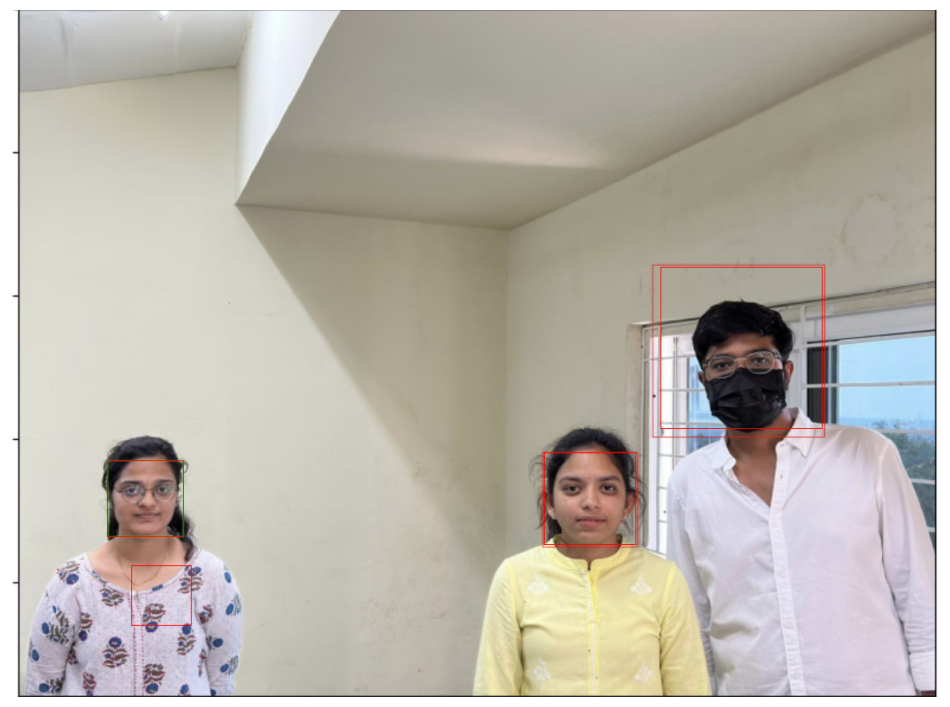

In [4]:
import cv2
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('/content/drive/MyDrive/Face Mask Dataset/images/s2.jpeg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Load the face detection model (for example, Haar Cascade)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect faces in the grayscale image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

# Check if any faces are detected
if len(faces) == 0:
    print("No faces detected")

# Draw rectangles around the detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 1)

# Convert the image to RGB (since OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot the image with detected faces
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


In [5]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('/content/drive/MyDrive/Haarcascades/haarcascade_frontalface_default.xml')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
MIN_DISTANCE = 500

In [8]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [9]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

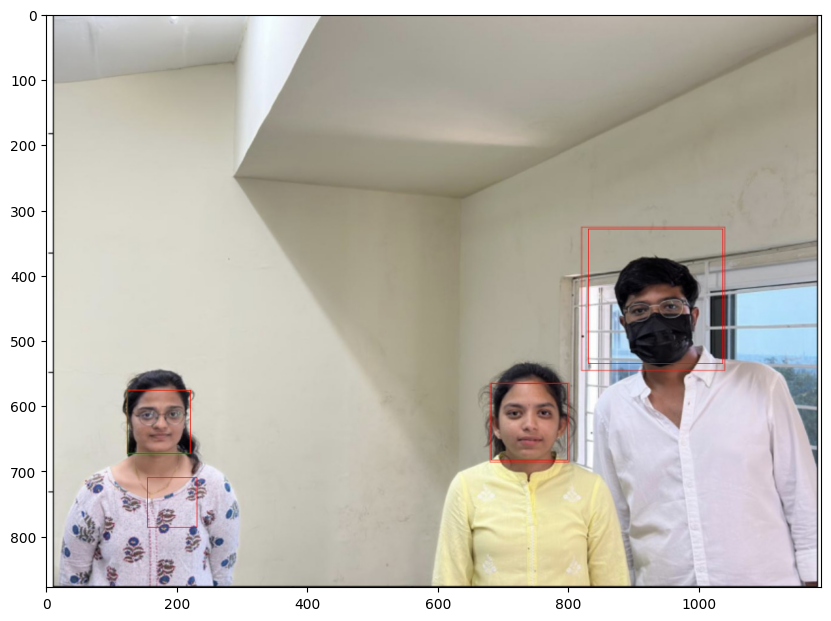

In [10]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
else:
    print("No. of faces detected is less than 2")

In [11]:
#Load train and test set
train_dir = '/content/drive/MyDrive/Face Mask Dataset/Test'
test_dir = '/content/drive/MyDrive/Face Mask Dataset/Train'
val_dir = '/content/drive/MyDrive/Face Mask Dataset/Validation'

In [12]:
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [13]:
vgg16 = VGG16(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg16.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 14731074 (56.19 MB)
Trainable params: 16386 (64.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [14]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [15]:
history = model.fit(train_generator, epochs=3, validation_data=val_generator)

Epoch 1/3
31/31 [==============================] - 397s 13s/step - loss: 0.2529 - accuracy: 0.8942 - val_loss: 0.1267 - val_accuracy: 0.9463
Epoch 2/3
31/31 [==============================] - 15s 475ms/step - loss: 0.0817 - accuracy: 0.9688 - val_loss: 0.0643 - val_accuracy: 0.9850
Epoch 3/3
31/31 [==============================] - 14s 472ms/step - loss: 0.0496 - accuracy: 0.9839 - val_loss: 0.0518 - val_accuracy: 0.9887


In [16]:
model.evaluate(test_generator)

25/25 [==============================] - 8s 315ms/step - loss: 0.0498 - accuracy: 0.9887


[0.04983561113476753, 0.9887499809265137]

In [17]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

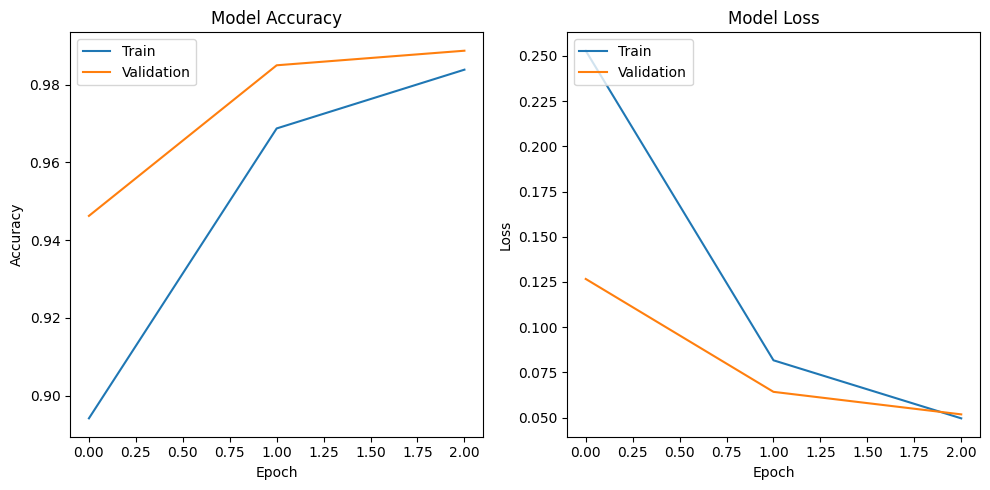

In [18]:
plot_training_history(history)

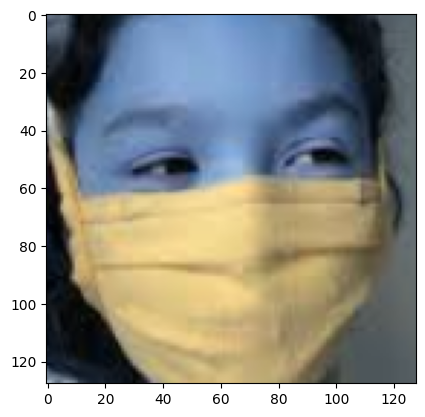

In [19]:
sample_mask_img = cv2.imread('/content/drive/MyDrive/Face Mask Dataset/Test/WithMask/1565.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [20]:
model.predict(sample_mask_img)

1/1 [==============================] - 1s 1s/step


array([[0.7816736 , 0.13805126]], dtype=float32)

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
y_true = test_generator.classes

# Assuming you have model.predict() for obtaining predicted labels (y_pred)
y_pred = model.predict(test_generator)

# Convert predicted probabilities to class predictions
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Generate a classification report
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:")
print(class_report)

25/25 [==============================] - 7s 271ms/step
Confusion Matrix:
[[210 190]
 [186 214]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.53      0.53       400
           1       0.53      0.54      0.53       400

    accuracy                           0.53       800
   macro avg       0.53      0.53      0.53       800
weighted avg       0.53      0.53      0.53       800



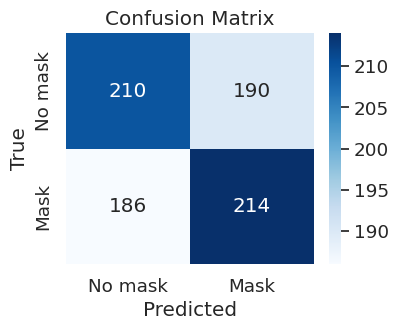

In [23]:
import seaborn as sns
class_labels = ['No mask', 'Mask']
# Create a heatmap
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
model.save('masknet_vgg16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

1/1 [==============================] - 0s 18ms/step


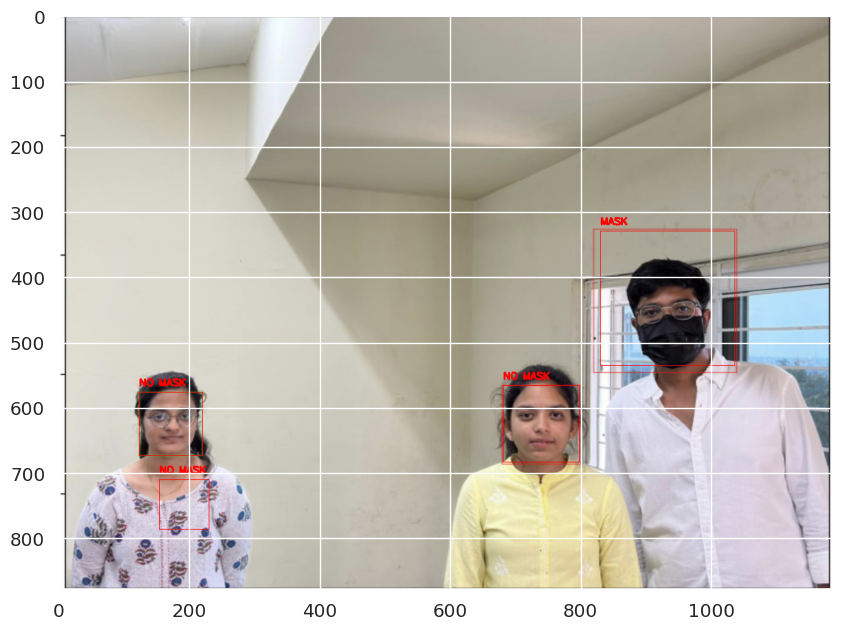

In [26]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)

else:
    print("No. of faces detected is less than 2")